# Non-boltzman (enhanced) sampling ideas

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import ipywidgets as widgets

from numpy.random import rand, random, randint, choice, normal, uniform 

from numba import jit, njit
import warnings
warnings.filterwarnings('ignore')

Suppse we have a system in NVT ensemble described by energy function $E_{\nu}$  which makes it hard to sample via straight MCMC. 
We can introduce a bias in the energy function $E^0_{\nu}$ with an objective to accelerate the sampling and eliminate the energetic barriers present with the original system.  

$$E^0_{\nu} = E_{\nu} - \Delta E$$

- $E_{\nu}$   Energy function of an unbiased system
- $E^0_{\nu}$ Energy function of a biased system.
- $\Delta E_{\nu}$ bias term. 

#### Boltzman exponent factorization to the rescue!

$$Z = \sum_{\nu} e^{-\beta E_{\nu}}  = \frac{Z_0}{Z_0} \sum_{\nu} e^{-\beta E^0_{\nu}} e^{-\beta \Delta E_{\nu}} = Z_0 \langle e^{-\beta \Delta E_{\nu}} \rangle_0 $$

$$\boxed{\frac{Z}{Z_0} = e^{-\beta(F-F_0)} = \langle e^{-\beta \Delta E_{\nu}} \rangle_0}$$

Where $\langle ... \rangle_0$ indicates canonical average with $E^0_{\nu}$.

Any observable of interest can now be expressed in terms of ensemble average conducted with biased energy function $E_0$

$$\langle G\rangle = \frac{1}{Z}\sum_{\nu} G_{\nu}e^{-\beta E_{\nu}}  = \frac{Z_0}{Z} \langle G_{\nu} e^{-\beta \Delta E_{\nu}} \rangle_0 $$

## Umbrella Sampling

$$E_{\nu} =  E^0_{\nu}+ W_{\nu}$$

- Where $W_{\nu} \approx 0$ in the interesting regions
<br><br>
- Where $W_{\nu} \gg 0$ outside of interesting regions
<br><br>
- Read more about US in [J Kastner; WIREs Comp Mol Sci (2011)](https://onlinelibrary.wiley.com/doi/full/10.1002/wcms.66?casa_token=KxOXA8oqPO4AAAAA%3AR78Iv0cMhe3NaCNe86T0AnQBJ57euERM3h20FTeSRcM9wOzEHIJq-6FD7J4_kZHg4UZ1RKuGm_OoCPw)

![](./figs/umbrella-1.png)

### Connection between biased and unbiased simulations:

- Free energy as a function of order parameter defined as log of partial sum of parition function

$$Z(m) = \sum_{\nu}e^{-\beta E(s_{\nu})}\cdot \delta(M(s_{\nu})-m)  = e^{-\beta F(m)}$$

- Histogram of order parameter in the simulatons as a ratio of partial and full partition functions

$$p(m) = \frac{Z(m)}{Z} = \langle \delta(M(s)-m) \rangle = e^{-\beta(F(m)-F)}$$

- Free eenergy computed as a histogram of order parameter

$$F(m) =  -\frac{1}{\beta}log\, Z(m) = -\frac{1}{\beta}log\, p(m) +const$$

### Connection between biased and unbiased simulations

$$p_0(m) = \langle \delta(M(s)-m) \rangle_0 =e^{-\beta w(m)} \frac{\sum_{\nu} \delta(M(s_{\nu})-m) e^{-\beta E_{\nu}}}{Z_0} =    \frac{e^{-\beta w(m)} p(m)}{Z_0/Z}$$

$$F(m) = F^0(m) - w(m)+C$$

For simulation with multiple windows $w_i$ there is an undetermined constant which is optimized to obtain smooth free energy profile and reduce the statistical noise

$$F_i(m) = F_i^0(m) - w_i(m)+C_i$$

In [77]:
#Ising2D python code optimized for speed

import numpy  as np
import pandas as pd
from numba import jit, njit

@njit
def compute_ising2d(spins, J, B):
    '''Computes thermodynamic variables given the spin lattice'''
  
    N = len(spins)

    E=0
    for i in range(N):
        for j in range(N):   
            z = spins[(i+1)%N, j] + spins[(i-1)%N, j] +spins[i,(j+1)%N] +  spins[i,(j-1)%N]
                
            E += -J*z*spins[i,j]/4 # Since we overcounted interactions 4 times divide by 4.

    #Magnetization
    M   = np.mean(spins)

    #Energy
    E = E/N**2 - B*M

    return M, E  

@njit
def run_ising2d(spins, J, B, T, n_steps, out_freq, umbrella = np.array([-1.0, 1.0])):

    #Initialize data arrays
    Magn, Ener, traj = [], [], []
    N = len(spins)

    for step in range(n_steps):

        i, j = np.random.randint(N), np.random.randint(N)
        z  = spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i, (j+1)%N] + spins[i, (j-1)%N] 
        dE     = 2*spins[i,j]*(J*z + B)  

        #Metropolis condition
        if np.exp(-dE/T) > np.random.rand() and ( umbrella.min() < np.mean(spins) - 2*spins[i,j]/N**2 < umbrella.max() ):

            spins[i,j] *= -1 
            
        #Compute and store data
        if step % out_freq == 0:

            M_t, E_t = compute_ising2d(spins, J, B)
            
            Magn.append(M_t)
            Ener.append(E_t)
            traj.append(spins.copy())

    return traj, Ener, Magn

![](./figs/umbrealla-2.png)

In [73]:
# Estimate lattice size needed by calculating difference in magnetization caused by a spin flip 2/N**2
traj, E, M = run_ising2d(spins=np.ones((20,20)), J=1, B=0, T=2, n_steps=1e6, out_freq=1e3, umbrella = np.array([0.8, 1]) )

0.93 0.805


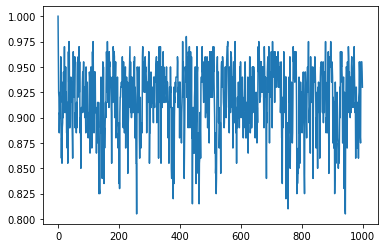

In [74]:
plt.plot(M)
print(M[-1], min(M))

In [75]:
umb = np.array([M[-1]-0.2, M[-1] ]) 

traj2, E2, M2 = run_ising2d(spins=traj[-1], J=1, B=0, T=2, n_steps=1e6, out_freq=1e3, umbrella = umb )

(array([ 0.10526316,  0.10526316,  0.63157895,  0.84210526,  1.57894737,
         3.15789474,  6.36842105, 10.05263158, 15.        , 14.78947368]),
 array([0.74 , 0.759, 0.778, 0.797, 0.816, 0.835, 0.854, 0.873, 0.892,
        0.911, 0.93 ]),
 <a list of 10 Patch objects>)

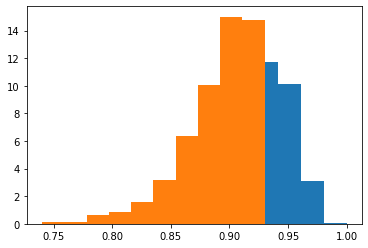

In [76]:
plt.hist(M,density=True)
plt.hist(M2,density=True)

In [66]:
@widgets.interact(i=(0,10))
def plot_image(i=1):
    plt.imshow(traj[i],origin='lower')

interactive(children=(IntSlider(value=1, description='i', max=10), Output()), _dom_classes=('widget-interact',…

##  Simulated annealing

Monte Carlo technique for the **numerical optimization** of functions

1. Original paper: [S. Kirkpatrick, C. D. Gelatt, Jr., M. P. Vecchi, Science 220, 671-680 (1983)](http://science.sciencemag.org/content/220/4598/671.long)

2. Remember: it is difficult to find the **global** extremum of a function

3. Idea: Monte Carlo search of the function domain

### Finding energy minima of any thermal  system $\leftrightarrow$ finding minimum of any abstract function

- Introduce (artificial) temperature parameter $T$
- Metropolis algorithm with acceptance probability min$(1, e^{-\Delta f/T})$
- Here $f$ can be any function we want to minimize (not only energy)
- For maximum simply change the sign: min$(1, e^{+\Delta f/T})$
- Slowly reduce the temperature

### "Slow cooling" is the main idea of simulated annealing

very high $T$                                |   very low $T$
---------------------------------------------|------------------------------------
almost all updates are accepted              | only updates that decrease the energy are accepted
random configurations/explore entire space   | descend towards minimum 
high energy                                  | low energy but might get stuck in local minimum
  
- if we slowly cool from high $T$ to low $T$ we will explore the entire space until we converge to the (hopefully) global minimum
- success is not guaranteed, but the methods works very well with good cooling schemes

- Inspiration: annealing in metallurgy. 

- This is a great method to tackle **NP-hard** optimization problems, such as the traveling salesman!

### Cooling schedules

- slow cooling is essential: otherwise the system will "freeze" into a local minimum
- but too slow cooling is inefficient...
- initial temperature should be high enough so that the system is essentially random and equilibrates quickly
- final temperature should be small enough so that we are essentially in the ground state (system no longer changes)
- exponential **cooling schedule** is commonly used

  $$\boxed{T(t)=T_0e^{-t/\tau}}$$
  
  where $t$ is the Monte Carlo time and the constant $\tau$ needs to be determined (usually empirically)
  
- alternative cooling schedules:

  linear: $T(t)=T_0 - t/\tau$ (also widely used)
  
  logarithmic: $T(t) = c/\log(1+t/\tau)$

### **Example:** find global minimum of the function via simulated annealing: $f(x) = x^2 -\cos (4\pi x)$

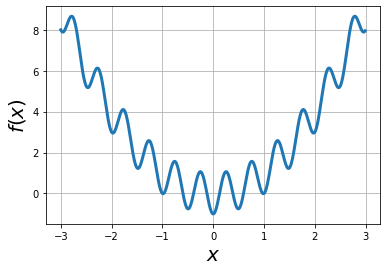

In [ ]:
f = lambda x: x*x - np.cos(4*np.pi*x) 
xvals = np.arange(-3,3,0.01)

plt.plot(xvals, f(xvals),lw=3)

plt.xlabel("$x$",fontsize=20)
plt.ylabel("$f(x)$",fontsize=20)
plt.grid(True)

#### Search for global minima of $f(x)$ using simulated annealing

In [ ]:
def MCupdate(T, x, mean, sigma):
    
    '''Making a new move by incremening a normal distributed step
    We are exploring function diffusivefly, e.g doing random walk!
    T: temp
    mean, sigma: parameters of random walk
    '''
    
    xnew = x + normal(mean, sigma)
    
    delta_f = f(xnew) - f(x)
    
   
    if delta_f < 0 or np.exp(-delta_f/T) > rand():
        
        x = xnew
        
    return x


def cool(T, cool_t):
    
    '''Function for educing T after every MC step. 
    
    cool_t: cooling time tau for exponential schedule 
    Alternatively we could reduce every N steps.'''
    
    return T*np.exp(-1/cool_t)

In [ ]:
def sim_anneal(T=10, T_min=1e-4, cool_t=1e4, x=2, mean=0, sigma=1):
    
    '''Simulated annealing search for min of function:
    
    T=T0:        starting temperature
    T_min:       minimal temp reaching which sim should stop
    cool_t:      colling pace/time
    x=x0:        starting position 
    mean, sigma: parameters for diffusive exploration of x'''
    
    xlog   = []

    while T > T_min:
    
        x = MCupdate(T, x, mean, sigma)
    
        T = cool(T, cool_t)
   
        xlog.append(x)
    
    return xlog

Final search result for the global minimum:  -0.0014663691677841409


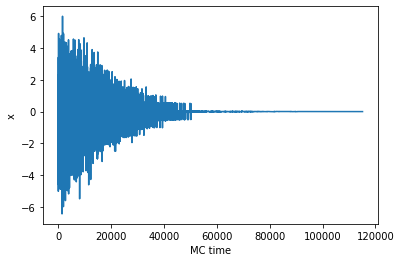

In [ ]:
xlog = sim_anneal()

plt.plot(xlog)

plt.xlabel('MC time')
plt.ylabel('x')
print('Final search result for the global minimum: ', xlog[-1])

In [ ]:
@widgets.interact(t_sim=(1,1000))
def viz_anneal(t_sim=1):
    
    T           = 4
    x           = 2
    cool_t      = 1e4
    mean, sigma = 0, 1
    
    plt.plot(xvals, f(xvals),lw=3, color='green')
    
    for t in range(t_sim):
        
        x = MCupdate(T, x, mean=0, sigma=1)
    
        T = cool(T, cool_t)
    
    plt.plot(x, f(x),'o',color='red',ms=20,alpha=0.5)
    plt.ylim(-1,8)
    plt.xlim(-3,3)
    plt.grid(True)
    plt.xlabel('$x$',fontsize=20)
    plt.ylabel('$f(x)$',fontsize=20)

interactive(children=(IntSlider(value=1, description='t_sim', max=1000, min=1), Output()), _dom_classes=('widg…

#### Lessons learened In this example: for finding minimum of a continuous function

- always slightly above true minimum if $T>0$

- best combined with a steepest descent method

### Simulated annealing applied to MCMC sampling of 2D Ising model

In [ ]:
temperature = 10.0    # initial temperature
tempmin = 1e-4        # minimal temperature (stop annealing when this is reached)
cooltime = 1e4        # cooling time tau for exponential schedule

# how long it will take to cool to minimal temperature in MC steps
MCtime = -cooltime*np.log(tempmin/temperature)

# after every MC step we reduce the temperature
def cool(temperature):
    
    return temperature*np.exp(-1/cooltime)

### Parallel tempering

1. **Simulated annealing is not guaranteed to find the global extremum**
    - Unless you cool infinitely slowly. 
    - Usually need to repeat search multiple times using independent simulations.
<br><br>

2. **Automating and generalizing sim annealing: parallel tempering (aka Replica Exchange MCMC)**

    - Simulate several copies of the system in parallel
    - Each copy is at a different constant temperature $T$
    - Usual Metropolis updates for each copy
    - Every certain number of steps attempt to exchange copies at neighboring temperatures
    - Exchange acceptance probability is min(1, $e^{-\Delta f\Delta\beta}$)
    - If temperature difference small enough, the energy histograms of the copies will overlap and exhcanges will happen often. 
<br><br>

3. **Advantages of replica exchange:**

    - Exchanges allow to explore different extrema
    - More successful for complex functions/energy landscapes. Random walk in temperature space!
    - Detailed balance is maintained! (regular simulated annealing breaks detailed balance)

### How to choose Temperature distributions for replica exchange MCMC

- A dense temperature grid increases the exchange acceptance rates
- But dense T grid takes longer to simulate and more steps are needed to move from one temperature to another
- There are many options, often trial and error is needed
     - exchange acceptance probability should be between about 20% and 80%
     - exchange acceptance probability should be approximately temperature-independent
     - commonly used: geometric progression for $N$ temperatures $T_n$ between and including $T_{\rm min}$ and $T_{\rm max}$ (ensures more steps around $T_{\rm min}$)
     
       $$T_n = T_{\rm min}\left(\frac{T_{\rm max}}{T_{\rm min}}\right)^{\frac{n-1}{N-1}}$$
       
       
       
- make sure to spend enough time before swapping to achieve equilibrium!

### parallel tempering simulation

In [ ]:
######## Ising 2D+US ###########

@njit
def mcmc(spins, N, J, B, T, n_steps = 10000, out_freq = 1000):
    
    '''mcmc takes spin configuration and samples with given N,J,B,T 
    for n_steps outputing results every out_freq'''

    confs = [] 
    
    for step in range(n_steps):

        #Pick random spin
        i, j = randint(N), randint(N)

        #Compute energy change
        z  = spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i, (j+1)%N] + spins[i, (j-1)%N]
        dE = 2*spins[i,j]*(J*z + B)

        #Metropolis condition
        if dE <= 0 or np.exp(-dE/T) > rand():
            
            spins[i,j] *= -1 

        #Store the spin configuration
        if step % out_freq == 0:
            
            confs.append(spins.copy())
        
    return confs

@njit
def getM(spins):
    
    return np.mean(spins)


@njit
def getE(spins,N,J,B):    
    
    E = 0
    
    for i in range(N):
        for j in range(N):   
            
            z = spins[(i+1)%N, j] + spins[(i-1)%N, j] +spins[i,(j+1)%N] +  spins[i,(j-1)%N]
            
            E += -J*z*spins[i,j]/4 # Since we overcounted interactions 4 times divide by 4.

    return E - B*np.sum(spins) #Field contribution added

@jit
def temper(configs, N_repl):
    
    '''Randomly pick two adjacent replicas and attempt an exchange'''
    
    i       = np.random.randint(N_repl-1)
    j       = i+1
    
    deltaBeta      = 1/T[i] - 1/T[j]
    
    deltaEnergy    = getE(configs[i][-1],N,J,B) - getE(configs[j][-1],N,J,B)
    
    if deltaBeta*deltaEnergy < 0 or np.exp(-deltaBeta*deltaEnergy) > rand():
        
        configs[i][-1], configs[j][-1] = configs[j][-1], configs[i][-1]
        
    return configs

@jit
def pt_mcmc(N, J, B, T=[1, 0.1], n_exch=1000, n_steps=10000, out_freq=1000):
    
    N_repl     = len(T)
    configs    = [[choice([-1,1], (N,N))] for i in range(N_repl)]
    
    
    for exch_attempt in range(n_exch): #Exchange attemps
    
        configs = temper(configs, N_repl)
    
        for i in range(N_repl): #mcmc in between exchange attemps
    
            configs_new = mcmc(configs[i][-1],N, J, B, T[i])
    
            configs[i].extend(configs_new)
        
    return configs

In [ ]:
N = 20       # size of lattice in each direction
J = 1       # interaction parameter
B = 0       # magnetic field

T=[5.0, 0.01, 0.0008, 0.0007, 0.00016, 0.00010]

n_exch = 1000
n_steps=10000
out_freq=100

configs = pt_mcmc(N, J, B, T, n_exch, n_steps, out_freq)

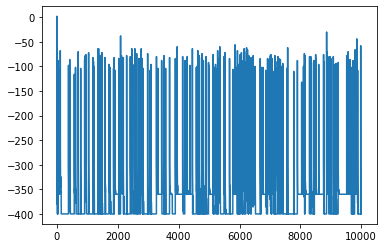

In [ ]:
E1 = [getE(spins,N,J,B) for spins in configs[1]]

plt.plot(E1)

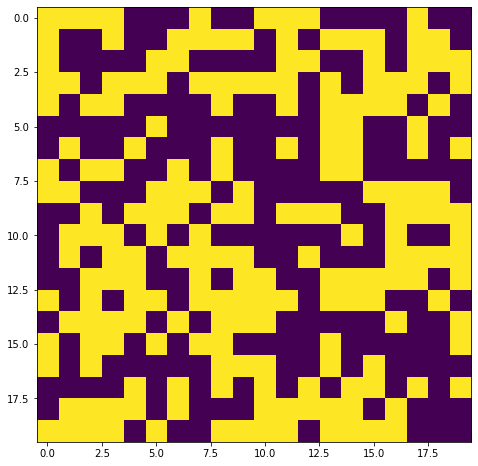

In [ ]:
@widgets.interact(i=(0,999))
def plot_image(i=1):
    
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(configs[0][i])

### Problems

1. **Umbrella Sampliing**

Use umbrealla sampling to obtain free energy profile as a function of magnetization below $T_c$ at $T_c$ and above $T_c$. E.g $T=2, 2.5, 3$ Consider using the inputs from adjecent umbrella simulations. E.g input for umbrella 4 can come from umbrella 3 to speed up simulations.

2. **Simulated Annealing**

Complete the simulated annealing part of the code for finding minimum energy in Ising models. Test your code with field on and off. 

3. **Parallel Tempering**

  Use parallell tempering to enhanced sampling at $T =1$ by coupling 8 replicas with $T>1$. Find the optimal T spacing between replicas, Calculate histograms of magnetization to show enhancment of sampling with repsect to constant T MCMC. 